In [1]:
# The imports we will need to run Constitutional Control
from numpy import isnan, mean
from scipy.stats import multivariate_normal
from promis import ConstitutionalController
from promis.geo import CartesianCollection, Location
import matplotlib.pyplot as plt

Doubt feature velocity v = 1
Compute and scatter landscape ...
Search and scatter path ...


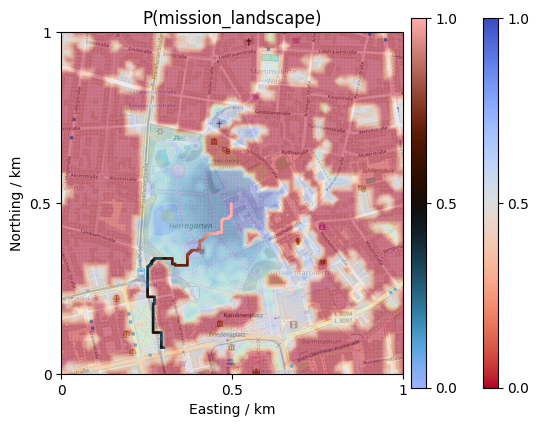

Doubt feature velocity v = 100
Compute and scatter landscape ...
Search and scatter path ...


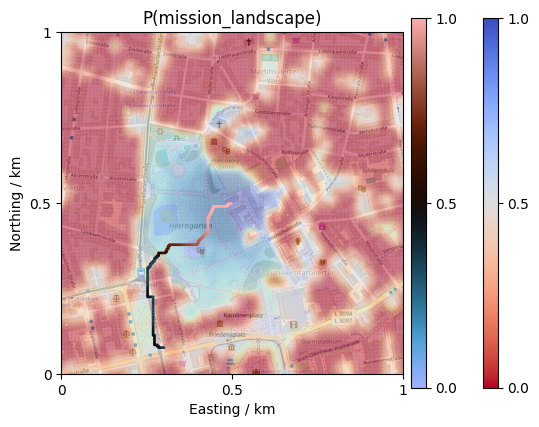

Doubt feature velocity v = 200
Compute and scatter landscape ...
Search and scatter path ...


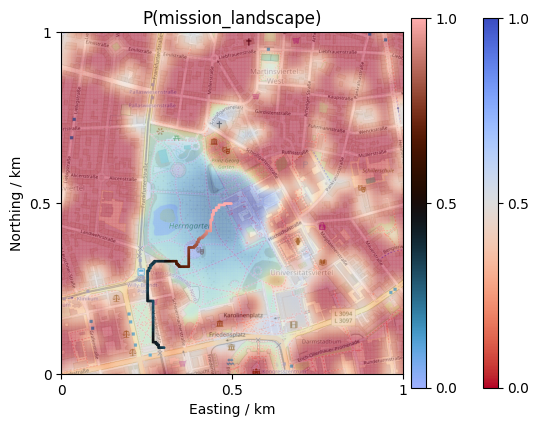

In [2]:
# Load the landscape produced by promis.ipynb and init CoCo
landscape = CartesianCollection.load(f"data/landscape.pkl")
coco = ConstitutionalController()

# Select different doubt feature values, here we have just one feature velocity
# and use it directly as doubt density parameter
for velocity in [1, 100, 200]:
    print(f"Doubt feature velocity v = {velocity}")
    print(f"Compute and scatter landscape ...")
    density = lambda n_samples: multivariate_normal([0.0, 0.0], [[velocity, 0.0], [0.0, velocity]]).rvs(n_samples)
    augmented_landscape = coco.apply_doubt(
        landscape=landscape, 
        doubt_density=density,
        number_of_samples=100
    )

    image = augmented_landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.25)
    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    print(f"Search and scatter path ...")
    start = (0.0, 0.0)
    goal = (-200.0, -425.0)
    path = augmented_landscape.search_path(start, goal, cost_model=lambda p: 1.0 - p, value_filter=lambda p: p > 0.3)
    interpolator = landscape.get_interpolator("hybrid")
    scatter = plt.scatter([n[0] for n in path], [n[1] for n in path], s=1, c=[
        coco.compliance(
            path=path,
            landscape=augmented_landscape, 
            doubt_density=density, 
            number_of_samples=100) 
        ],
        vmin=0, vmax=1, cmap="berlin"
    )
    cbar = plt.colorbar(scatter, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    ticks = [-500, 0, 500]
    labels = ["0", "0.5", "1"]

    plt.xlabel("Easting / km")
    plt.ylabel("Northing / km")
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title("P(mission_landscape)")
    plt.show()